## Step 1: Load the trained model

In [1]:
import torch
from GNN_model import VesselGNN

checkpoint = torch.load("best_vessel_gnn.pth", map_location="cpu")

model = VesselGNN()
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model loaded from epoch:", checkpoint["epoch"])


e:\GNN_model\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded from epoch: 99


## Step 2: Prepare New Patient Data

In [15]:
import pandas as pd
import torch
from torch_geometric.data import Data

df = pd.read_csv("../data/centerlines.csv")

# Node features
x = torch.tensor(df[['X', 'Y', 'Z', 'MaximumInscribedSphereRadius']].values,
                 dtype=torch.float)

# Build edges 
edge_index = []
for i in range(len(df) - 1):
    edge_index.append([i, i+1])
    edge_index.append([i+1, i])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

new_patient_data = Data(x=x, edge_index=edge_index)


## Step 3: Predict Blood Flow

In [17]:
with torch.no_grad():
    prediction = model(new_patient_data)
    
prediction.shape


torch.Size([5329, 16])

## Step 4: Save to csv file

In [18]:
pred_values = prediction.squeeze().numpy()
print(pred_values[:,0])

csv_output = pd.DataFrame({
    'NodeIndex': range(len(pred_values)),
    'PredictedRiskScore': pred_values[:,0]
})
csv_output.to_csv("predicted_risk_scores.csv", index=False)

[1.6319106 1.9310818 1.8626025 ... 0.5652424 0.5866477 0.5020303]


## Step 5: Visualization

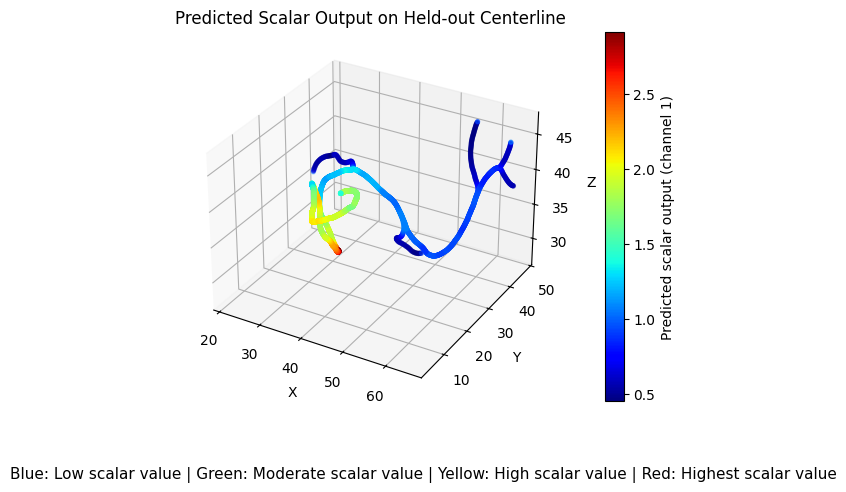

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = new_patient_data.x.numpy()   # geometry
pred_score = pred_values[:, 0]             # prediction

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    x[:,0], x[:,1], x[:,2],
    c=pred_score,
    cmap='jet',
    s=8
)

fig.text(
    0.5, -0.05,
    "Blue: Low scalar value | Green: Moderate scalar value | Yellow: High scalar value | Red: Highest scalar value",
    ha="center",
    fontsize=11
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(sc, label="Predicted scalar output (channel 1)", pad=0.1)
ax.set_title("Predicted Scalar Output on Held-out Centerline")
plt.show()





## Step 6: Radius vs Predicted Output along Vessel Centerline

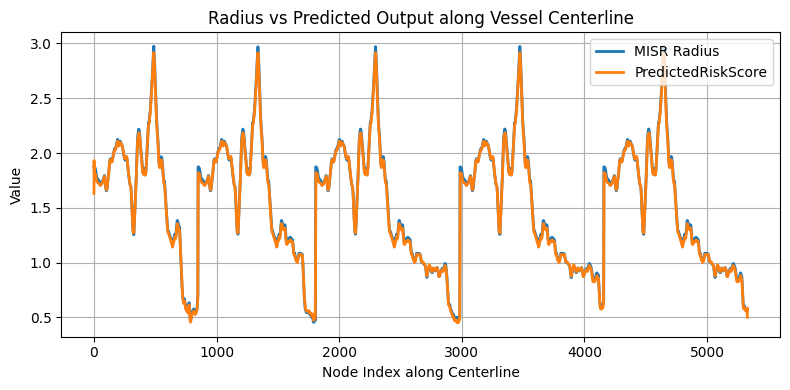

In [30]:
import numpy as np

radius = df["MaximumInscribedSphereRadius"].values
node_idx = np.arange(len(radius))
pred_score = pred_values[:, 0]

plt.figure(figsize=(8,4))
plt.plot(node_idx, radius, label="MISR Radius", linewidth=2)
plt.plot(node_idx, pred_score, label="PredictedRiskScore", linewidth=2)

plt.xlabel("Node Index along Centerline")
plt.ylabel("Value")
plt.title("Radius vs Predicted Output along Vessel Centerline")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
